In [1]:
import numpy as np
import pandas as pd

import datetime
import random as rd
import statsmodels.api as sm

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

import statsmodels.tsa.api as smt
import statsmodels.api as sn
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data1 = pd.read_csv("google-data.csv")
df = data1.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [3]:
df.sort_values(by = ["Date"] , ascending = False)

,Date,Open,High,Low,Close,Adj Close,Volume
1258,2017-12-29,1046.719971,1049.699951,1044.900024,1046.400024,1046.400024,887500
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1254,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
...,...,...,...,...,...,...,...
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500


# Converting Date's dtype to Date

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [5]:
df['date'] = pd.to_datetime(df['Date']).dt.strftime("%d/%m/%y")
df.drop(columns=['Date'], inplace=True)

In [6]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,date
0,357.385559,361.151062,355.959839,359.288177,359.288177,5115500,02/01/13
1,360.122742,363.600128,358.031342,359.496826,359.496826,4666500,03/01/13
2,362.313507,368.339294,361.488861,366.600616,366.600616,5562800,04/01/13
3,365.348755,367.301056,362.929504,365.001007,365.001007,3332900,07/01/13
4,365.393463,365.771027,359.874359,364.280701,364.280701,3373900,08/01/13
5,363.769043,366.789398,361.945892,366.675140,366.675140,4075700,09/01/13
6,369.014923,370.092896,364.380066,368.344269,368.344269,3695100,10/01/13
7,368.602600,368.816193,365.771027,367.604095,367.604095,2587000,11/01/13
8,366.118744,368.701935,358.841095,359.288177,359.288177,5765000,14/01/13
9,357.340851,365.125214,353.749207,360.122742,360.122742,7906300,15/01/13


# Dealing with missing weekends

In [7]:
data = pd.DataFrame()
data['date'] = pd.date_range(start = '2013-01-02', end = '2017-12-29')
data['date'] = data['date'].dt.strftime("%d/%m/%y")
data = data.merge(df, how = 'left', on = 'date')

In [8]:
data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,02/01/13,357.385559,361.151062,355.959839,359.288177,359.288177,5115500.0
1,03/01/13,360.122742,363.600128,358.031342,359.496826,359.496826,4666500.0
2,04/01/13,362.313507,368.339294,361.488861,366.600616,366.600616,5562800.0
3,05/01/13,NaN,NaN,NaN,NaN,NaN,NaN
4,06/01/13,NaN,NaN,NaN,NaN,NaN,NaN


## Imputing null values

In [9]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for n_col in numeric_cols:
  data[n_col]=data[n_col].interpolate(method = 'cubic')

In [10]:
data.isnull().sum()

date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Cecking for seasonality, trend, stasionarity

In [11]:
a = sn.tsa.seasonal_decompose(data.Close.values, freq = 365, model = 'additive')
m = sn.tsa.seasonal_decompose(data.Close.values, freq = 365, model = 'multiplicative')

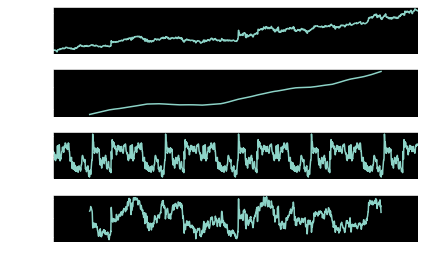

In [12]:
fig = m.plot()

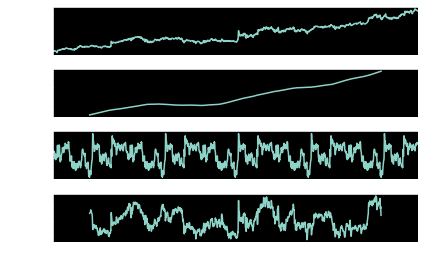

In [13]:
fig = a.plot()

In [14]:
def st_check(timeseries):
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
  
st_check(data.Close)

Test statistic                   -0.232731
p-value                           0.934506
#Lags Used                        5.000000
Number of Observations Used    1817.000000
Critical Value (1%)              -3.433954
Critical Value (5%)              -2.863132
Critical Value (10%)             -2.567618
dtype: float64


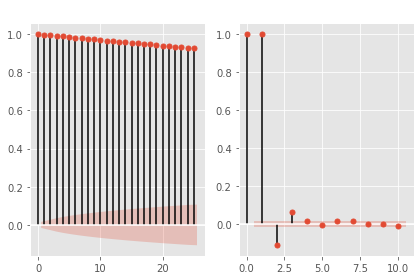

In [15]:
plt.style.use('ggplot')
l = (1,2)
a = plt.subplot2grid(l,(0,0))
p = plt.subplot2grid(l,(0,1))
smt.graphics.plot_acf(data.Close, lags = 25, ax = a, alpha = 0.5)
smt.graphics.plot_pacf(data.Close, lags = 10, ax = p, alpha = 0.5)
plt.tight_layout()

# PROPHET

In [16]:
model_df = data.loc[:, ['date', 'Close']].rename(columns = {"date":"ds", "Close":"y"})
model_df.head()

,ds,y
0,02/01/13,359.288177
1,03/01/13,359.496826
2,04/01/13,366.600616
3,05/01/13,369.244832
4,06/01/13,367.666599


In [17]:
model = Prophet(yearly_seasonality=True, interval_width = 0.95)
model.fit(model_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
ft = model.make_future_dataframe(periods = 95)
pred = model.predict(ft)
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1913,2018-03-30,1088.614230,994.037379,1188.631245
1914,2018-03-31,1087.520004,993.102522,1180.294011
1915,2018-04-01,1086.702508,993.461895,1184.585717
1916,2018-04-02,1086.191821,992.784044,1184.555544
1917,2018-04-03,1084.852871,995.309495,1171.196575


Text(0.5, 1.0, 'Google Stock Prices')

<Figure size 1152x576 with 0 Axes>

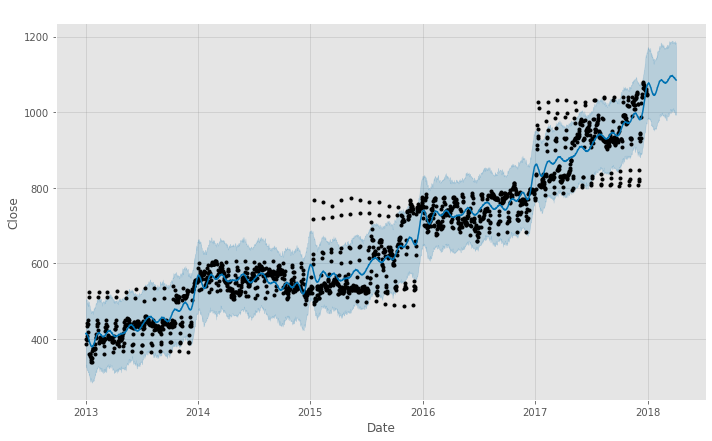

In [19]:
plt.figure(figsize = (16,8))
model.plot(pred, xlabel = 'Date', ylabel = 'Close')
plt.title('Google Stock Prices')

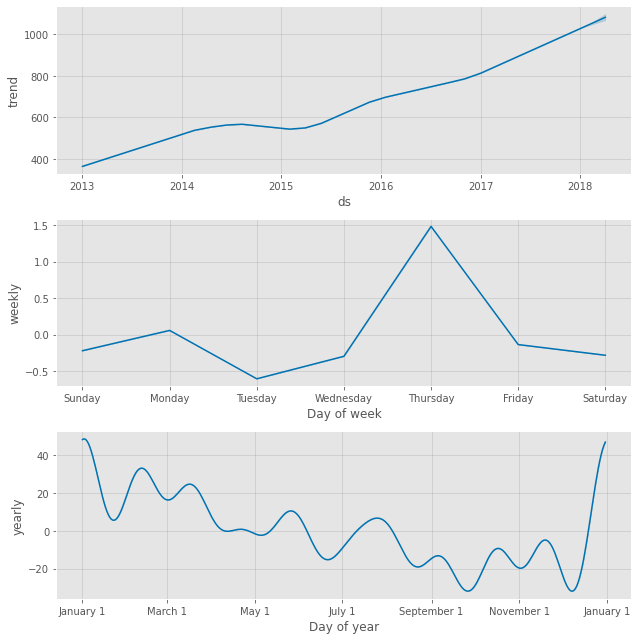

In [20]:
fig = model.plot_components(pred)

# HYPERPARAMETER TUNING

In [22]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
def optimization_function (changepoint_prior_scale, seasonality_prior_scale):
  model = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
  cross_val = cross_validation(model, horizon = '100 days', parallel = 'processes')
  perf_m = performance_metrics(cross_val, rolling_window = 1)
  rmse = (perf_m,['rmse'].values[0])
  print(rmse)
  return rmse

In [23]:
#!pip install bayesian-optimization

In [24]:
from pandas.core.common import random_state
from bayes_opt import BayesianOptimization
parameters = {'changepoint_prior_scale': [0.001, 0.5],
              'seasonality_prior_scale': [0.01, 10],
}

optimizer = BayesianOptimization(
    f = optimization_function,
    pbounds = parameters,
    random_state = 42,)

In [25]:
params_grid = {
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200],
                'seasonality_mode':('multiplicative','additive')}

In [26]:
from sklearn.model_selection import ParameterGrid
import random

In [27]:
par = ParameterGrid(params_grid)


In [28]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in par:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    train_model.fit(model_df)
    train_forecast = train_model.make_future_dataframe(periods=100, freq='D')
    train_forecast = train_model.predict(train_forecast)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.1, 'holida

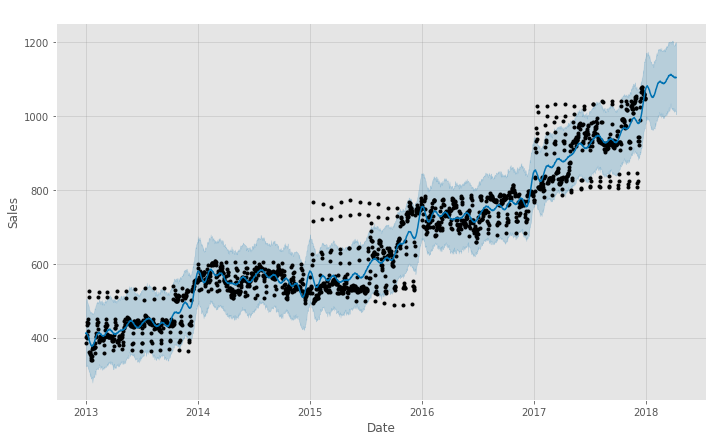

In [29]:
train_model.plot(train_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title("The Next 100 day's prediction")
plt.show()

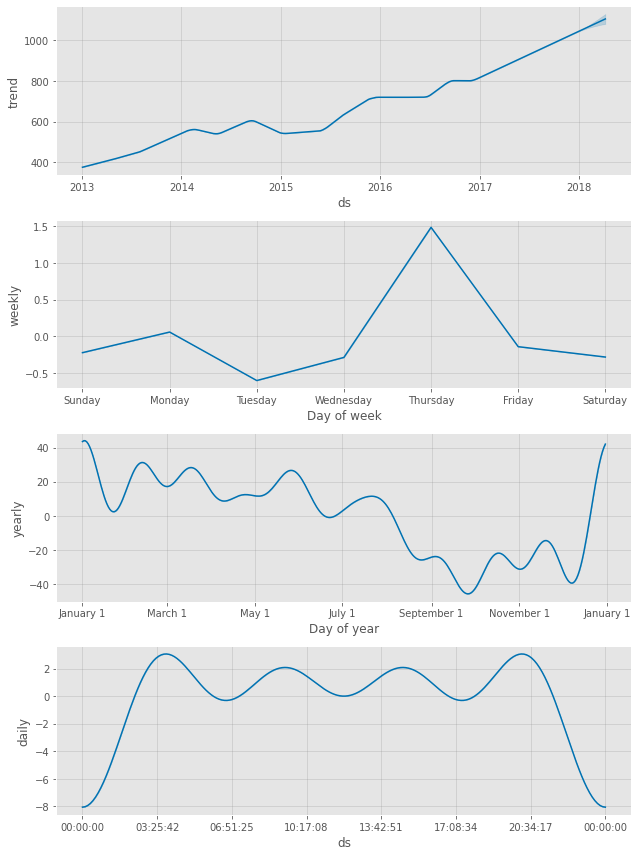

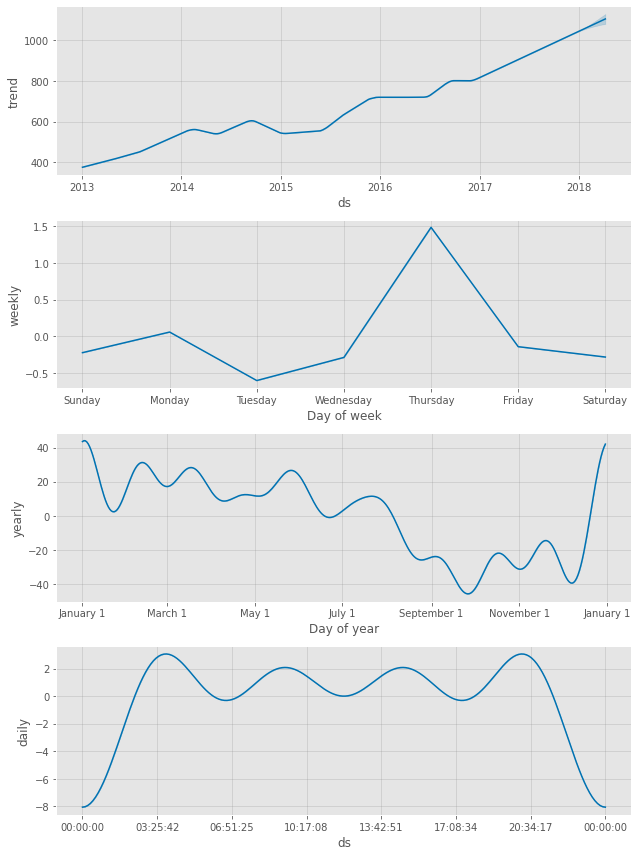

In [31]:
train_model.plot_components(train_forecast)